In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels as arima ## For Arima modeling 




In [3]:
file_path = "data\CMO-Historical-Data-Monthly.xlsx"




df = pd.read_excel(file_path, sheet_name='Monthly Prices', skiprows=4, engine='openpyxl')  
# print(df.head())



xls = pd.ExcelFile(file_path, engine='openpyxl')
# print(df.isnull().sum())
# To check for null or missing data

df.rename(columns={"Unnamed: 0": "Year"}, inplace=True)

df = df.drop([0, 1])
# Droped the names of $\bbl

df.replace('…', pd.NA, inplace=True)
# Alot of dotted values (missing) replaced with NA
df.fillna(method='bfill', inplace=True) # backward filling the missing values of coal in Australia and South Africa
# df.fillna(0,inplace=True)

print(df.head(10))

# print(xls.sheet_names)
# To List all sheet names  



       Year  Crude oil, average  Crude oil, Brent  Crude oil, Dubai  \
2   1960M01                1.63              1.63              1.63   
3   1960M02                1.63              1.63              1.63   
4   1960M03                1.63              1.63              1.63   
5   1960M04                1.63              1.63              1.63   
6   1960M05                1.63              1.63              1.63   
7   1960M06                1.63              1.63              1.63   
8   1960M07                1.63              1.63              1.63   
9   1960M08                1.63              1.63              1.63   
10  1960M09                1.63              1.63              1.63   
11  1960M10                1.63              1.63              1.63   

    Crude oil, WTI  Coal, Australian  Coal, South African **  Natural gas, US  \
2             35.3               7.8                   29.34             0.14   
3             35.3               7.8                   2

C:\Users\pc\AppData\Local\Temp\ipykernel_16220\2678691202.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('…', pd.NA, inplace=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_16220\2678691202.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True) # backward filling the missing values of coal in Australia and South Africa
C:\Users\pc\AppData\Local\Temp\ipykernel_16220\2678691202.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_

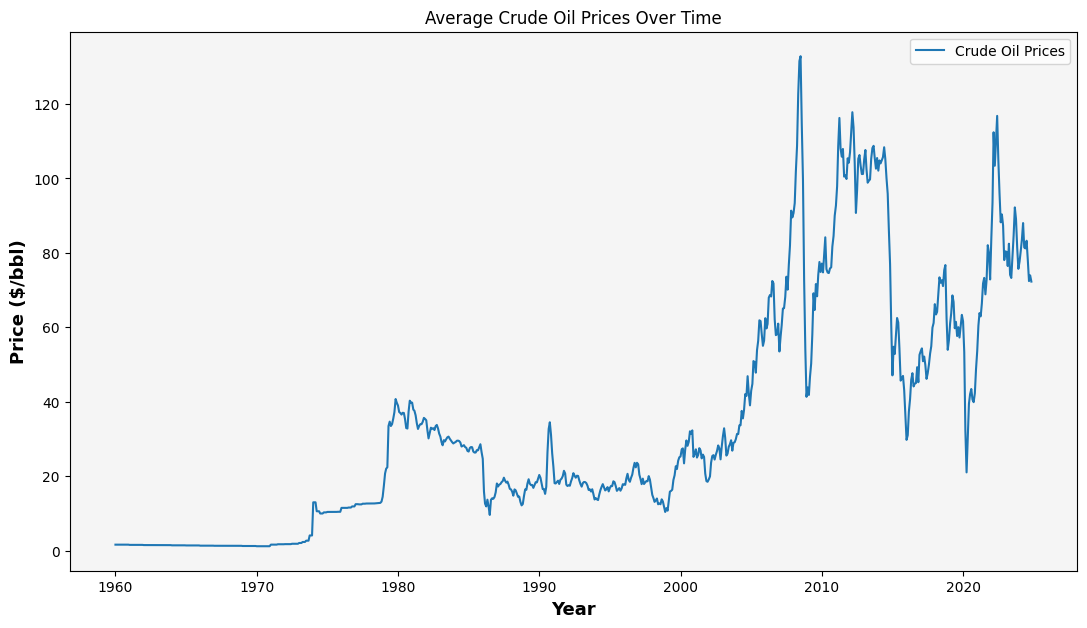

In [4]:

# print(df.columns)
# print(df.info())
df['Date'] = pd.to_datetime(df['Year'], format='%YM%m') # Convert it to time instead of just shwoing numbers
df.set_index('Date', inplace=True) # Set Date column as index
plt.figure(figsize=(13,7))
plt.plot(df['Crude oil, average'], label='Crude Oil Prices')
plt.title('Average Crude Oil Prices Over Time')
plt.xlabel('Year', fontweight = 'bold', fontsize = '13')
plt.ylabel('Price ($/bbl)', fontweight = 'bold', fontsize = '13')
plt.legend()
plt.gca().set_facecolor('whitesmoke')


In [ ]:
from statsmodels.tsa.stattools import adfuller # For Augmented Dicky Fuller Test

series = adfuller(df['Crude oil, average'])

print(f'ADF Statistic: {series[0]}')
print(f'p-value: {series[1]}')
print('Critical Values:')
for key, value in series[4].items():
    print(f'   {key}: {value}')

# This basically prints the statistics such as the p value to know if stationary or not.

if series[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

# In this case the p value was above 0.05, therefore the series is not stationary

ADF Statistic: -1.7166884853092654
p-value: 0.4225352266727478
Critical Values:
   1%: -3.4388489336836003
   5%: -2.865291103159288
   10%: -2.568767459327767
The series is not stationary.


In [6]:
df['Crude oil, average'] = df['Crude oil, average'].diff()

from statsmodels.tsa.stattools import adfuller # For Augmented Dicky Fuller Test

series = adfuller(df['Crude oil, average'].dropna())

print(f'ADF Statistic: {series[0]}')
print(f'p-value: {series[1]}')
print('Critical Values:')
for key, value in series[4].items():
    print(f'   {key}: {value}')

# This basically prints the statistics such as the p value to know if stationary or not.

if series[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

# In this case the p value was under 0.05, therefore the series is stationary

ADF Statistic: -12.874913291563438
p-value: 4.792077333919793e-24
Critical Values:
   1%: -3.4388489336836003
   5%: -2.865291103159288
   10%: -2.568767459327767
The series is stationary.


In [7]:
from scipy import stats

# Now we need to make the variance stationary.
# Therefore,I chose the Box-Cox method to do that.



non_positive_values_after_diff = df['Crude oil, average'].min()
print(f"Min value after differencing: {non_positive_values_after_diff}")

if non_positive_values_after_diff <= 0:
    shift_value = abs(non_positive_values_after_diff) + 1
    df['Crude oil, average'] = df['Crude oil, average'] + shift_value
    
# To make negative values affected by diff to positive values.   
    
# print(f"Min value after shifting: {df['Crude oil, average'].min()}")    

df['Crude oil, average'] = df['Crude oil, average'].bfill() # I had 3 NAN values at the head, so I backward filled them.


print(df['Crude oil, average'].isna().sum())




df['Crude oil, average'], fitted_lambda = stats.boxcox(df['Crude oil, average']) # Box-Cox method doesn't allow NAN, zero values or negative values
print(f'Lambda used for Box-Cox transformation: {fitted_lambda}')

Min value after differencing: -26.96401405358
0
Lambda used for Box-Cox transformation: 1.8748654746613518


ADF Statistic: -7.054303836906886
p-value: 5.425046490980874e-10
Critical Values:
   1%: -3.438938229437747
   5%: -2.8653304587462944
   10%: -2.568788425002056
The series is stationary.


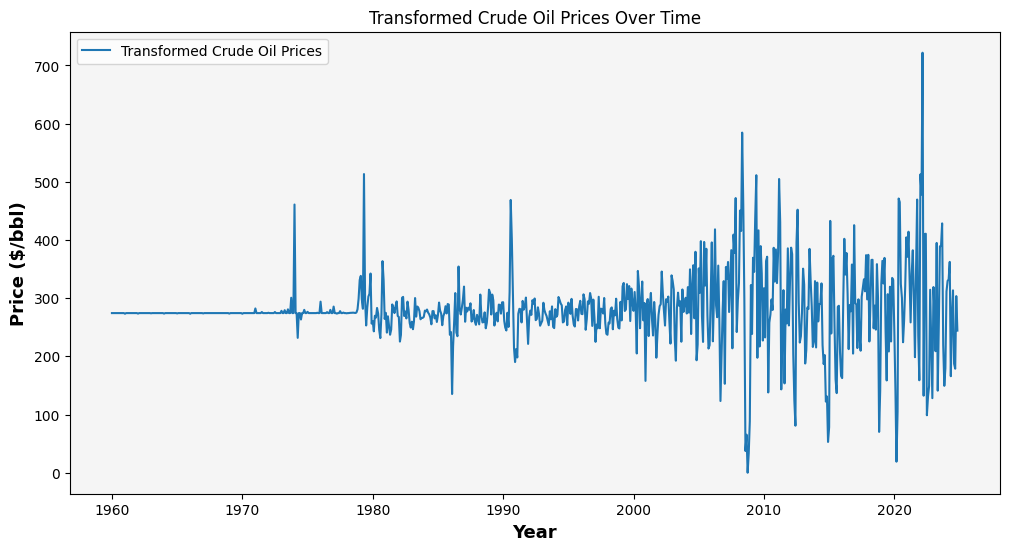

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['Crude oil, average'], label='Transformed Crude Oil Prices')
plt.title('Transformed Crude Oil Prices Over Time')
plt.xlabel('Year', fontweight = 'bold', fontsize = '13')
plt.ylabel('Price ($/bbl)', fontweight = 'bold', fontsize = '13')
plt.legend()
plt.gca().set_facecolor('whitesmoke')

# Rechecking if series is stationary after transformation

result = adfuller(df['Crude oil, average'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")


Text(0.5, 1.0, 'ACF Plot')

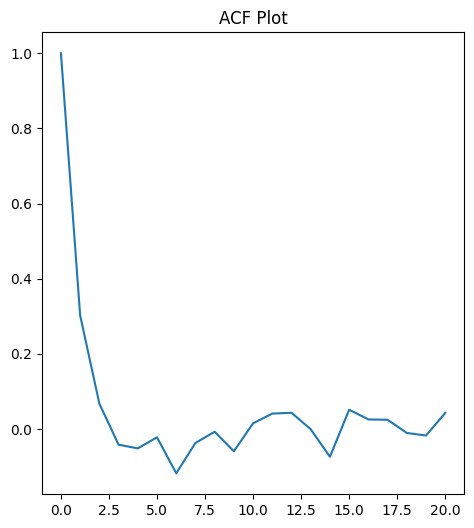

In [9]:




series = df['Crude oil, average']  

# Convert to numeric values, forcing errors to NaN, and drop NaN values
series = pd.to_numeric(series, errors='coerce')


series_clean = series.dropna()


if series_clean.empty:
    print("The series is empty after removing NaN values.")
else:
    
    series_diff = series_clean.diff().dropna()
   
# ACF
    
from statsmodels.tsa.stattools import adfuller, acf, pacf

acf_values = acf(series, nlags=20)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_values)
plt.title('ACF Plot')




Text(0.5, 1.0, 'PACF Plot')

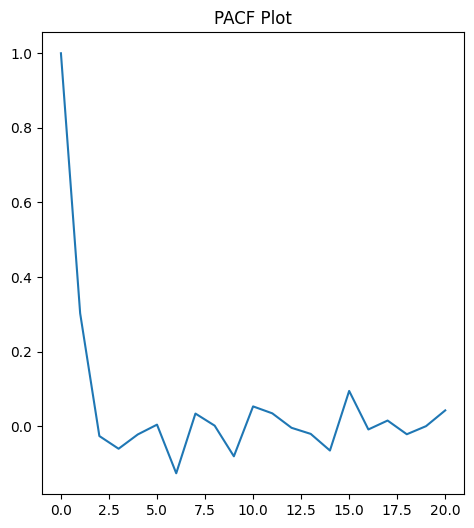

In [10]:
# PACF

from statsmodels.tsa.stattools import pacf
pacf_values = pacf(series_clean, nlags=20)
plt.figure(figsize=(12, 6))
plt.subplot(122)
plt.plot(pacf_values)
plt.title('PACF Plot')


In [15]:
# Now we must split the dataset to training set and testing set, 70-80% of the data for training and 20-30% test set.

train  = df['Crude oil, average']  
train  = pd.to_numeric(train , errors='coerce')  
train  = train.dropna()

training_size = int(len(train)*0.8) # 80% training
train, test = series[:training_size], series[training_size:]

train = train.astype(float)
test = test.astype(float)

from statsmodels.tsa.arima.model import ARIMA

p = 2
q = 2
d = 1

# p,d, and q must be integers



model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as startin

                               SARIMAX Results                                
Dep. Variable:     Crude oil, average   No. Observations:                  623
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3262.628
Date:                Sun, 05 Jan 2025   AIC                           6535.257
Time:                        20:28:24   BIC                           6557.422
Sample:                    01-01-1960   HQIC                          6543.871
                         - 11-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6224      0.057    -10.948      0.000      -0.734      -0.511
ar.L2          0.3191      0.030     10.784      0.000       0.261       0.377
ma.L1         -0.0223      0.054     -0.410      0.6

In [ ]:
# Okay now we have to check forecast.
# We compare forcast result with test data.

forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)




from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
# Compare MSE and MAE to check.
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 4804.172461301599
Mean Absolute Error: 42.62889850151289


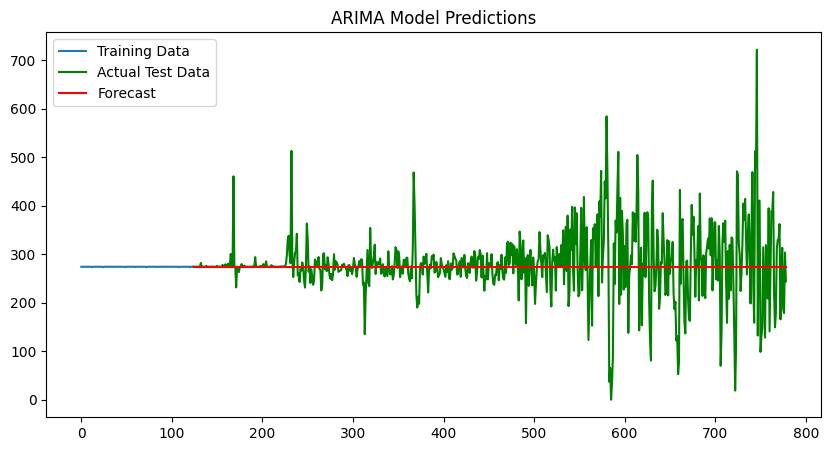

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train)), train, label="Training Data")
plt.plot(range(len(train), len(train) + len(test)), test, label="Actual Test Data", color="green")
plt.plot(range(len(train), len(train) + len(forecast)), forecast, label="Forecast", color="red")
plt.title("ARIMA Model Predictions")
plt.legend()

c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\OneDrive - Beirut Arab University\Desktop\Crude Oil Project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     Crude oil, average   No. Observations:                  124
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -16.093
Date:                Sun, 05 Jan 2025   AIC                             38.187
Time:                        21:04:49   BIC                             46.624
Sample:                    01-01-1960   HQIC                            41.614
                         - 04-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6613      0.070     -9.401      0.000      -0.799      -0.523
ar.L2         -0.3280      0.071     -4.588      0.000      -0.468      -0.188
sigma2         0.0757      0.005     16.676      0.0

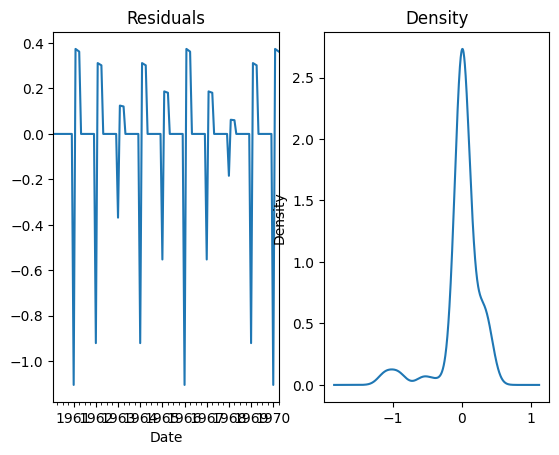

In [43]:

# Now we must split the dataset to training set and testing set, 70-80% of the data for training and 20-30% test set.

train  = df['Crude oil, average']  
train  = pd.to_numeric(train , errors='coerce')  
train  = train.dropna()

training_size = int(len(train)*0.8) # 80% training
train, test = series[:training_size], series[training_size:]

train = train.astype(float)
test = test.astype(float)

from statsmodels.tsa.arima.model import ARIMA

p = 2
q = 0
d = 1

# p,d, and q must be integers



model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()

residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind='kde', ax = ax[1])



print(model_fit.summary())